In [35]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [36]:
data = pd.read_csv('car-reviews.csv')

positive_data = data[691:]
negative_data = data[:691]

train_positive = positive_data[:553]
test_positive = positive_data[553:]

train_negative = negative_data[:553]
test_negative = negative_data[553:]

raw_training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
raw_testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

raw_training_data['Sentiment'] = np.where(raw_training_data['Sentiment'] == 'Pos', 1, 0)
raw_testing_data['Sentiment'] = np.where(raw_testing_data['Sentiment'] == 'Pos', 1, 0)

In [41]:
# Data Preparation

tr_texts = list(raw_training_data['Review'])
tr_labels = list(raw_training_data['Sentiment'])  

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_texts)
sequences = tokenizer.texts_to_sequences(tr_texts)

data = pad_sequences(sequences, maxlen=100)




# Model definition with regularization and dropout
model = Sequential([
    Input(shape=(100,)),  # Input shape corresponding to the padded sequence length
    Embedding(input_dim=10000, output_dim=128),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.005))  # L2 regularization on Dense layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# Training

labels = np.array(tr_labels)

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Training with early stopping
history = model.fit(data, labels, batch_size=32, epochs=10, validation_split=0.2, callbacks=[early_stopping])


# Evaluation

tes_texts = list(raw_testing_data['Review'])
tes_labels = list(raw_testing_data['Sentiment'])   

test_sequences = tokenizer.texts_to_sequences(tes_texts)
test_data = pad_sequences(test_sequences, maxlen=100)

probabilities = model.predict(test_data)


predictions = []

for idx in range(len(probabilities)):
    if probabilities[idx][0] > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)


accuracy = np.sum(predictions == np.array(tes_labels)) / len(tes_labels)
print(f"Accuracy: {round(accuracy, 3)}")

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6129 - loss: 0.6917 - val_accuracy: 0.0000e+00 - val_loss: 0.9175
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6272 - loss: 0.6291 - val_accuracy: 0.0766 - val_loss: 0.9135
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7723 - loss: 0.5307 - val_accuracy: 0.2658 - val_loss: 1.0931
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.507


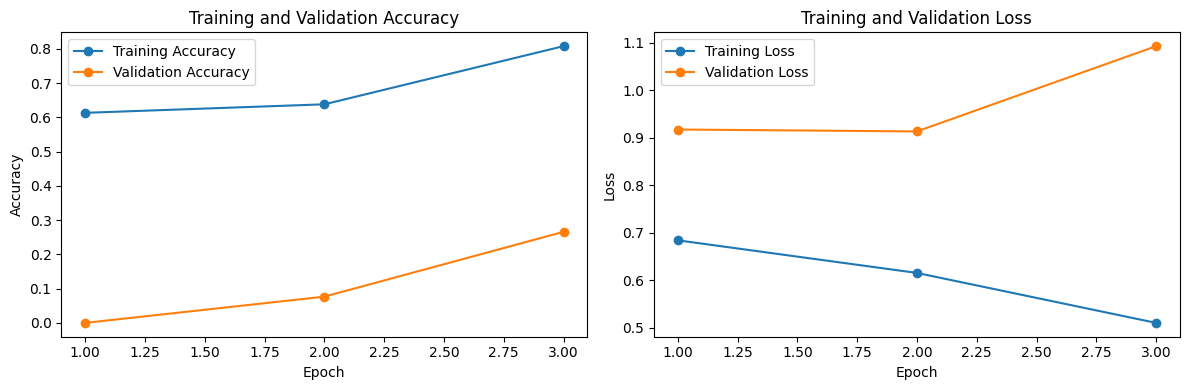

In [42]:
# Training history data
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()